In [31]:
#Neural Style Transfer
#use VGG19

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from google.colab import files
from io import BytesIO
from PIL import Image

In [32]:
# download images
upl = files.upload()
img = Image.open(BytesIO(upl['car.jpeg']))
img_style = Image.open(BytesIO(upl['kids.jpeg']))

Saving car.jpeg to car (3).jpeg
Saving kids.jpeg to kids (11).jpeg


In [33]:
# crop and resize images
width, height = img.size
a = min(width, height)
img = img.crop((0, 0, a, a))
img = img.resize((224,224))

width, height = img_style.size
a = min(width, height)
img_style = img_style.crop((0, 0, a, a))
img_style = img_style.resize((224,224))

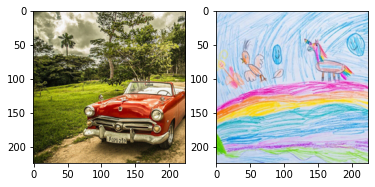

In [34]:
# Show images
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_style)
plt.show()

In [35]:
# preparing the images to special format for VGG #RGB -> BGR with channel offset
x_img = tf.keras.applications.vgg19.preprocess_input(np.expand_dims(img, axis=0))
x_style = tf.keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))

In [36]:
# Function for format Images back in the end (BGR+offset -> RGB)
def deprocess_img(processed_img):
  x = processed_img.copy()
  # remove 0 axe (4-th dimension)
  if len(x.shape) == 4:
    x = np.squeeze(x, axis=0)
  # chek is 3 axe really, error message
  assert len(x.shape) == 3, ("input to deprocess image must be an image of " 
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocess image")

  # Add the offset to color channels
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # BGR -> RGB
  x = x[:, :, ::-1]

  # all values <0 will =0, >255 will = 255
  x = np.clip(x, 0, 255).astype('uint8')

  return x

In [37]:
# Choose the layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',]
# count the number of layers
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [38]:
# download VGG19 without fully connected layer
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False # frozen the wheights of vgg (we don't need to train it)

In [39]:
# group the outputs from choosen layers
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

print(vgg.outputs)
for m in model_outputs:
  print(m)

# groups layers into an object
model = keras.models.Model(vgg.input, model_outputs)
print(model.summary())


[<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_pool')>]
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512)

In [40]:
# find style and content features
def get_feature_representations(model):
  
  # download into NN preparing image and image_style
  style_outputs = model(x_style)
  content_outputs = model(x_img)

  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  
  return style_features, content_features

In [41]:
#count content loss
# base_content - we get it if download into NN image
# target - we get it if download into NN image_style
def get_content_loss(base_content, target):
  # mean arithmetical value of (base_content - target)^2
  return tf.reduce_mean(tf.square(base_content - target))

In [42]:
# count style loss 

# Gram matrix (input_tensor=[n_height,n_width, channels])
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels]) #3D tensor [n_height,n_width, channels] -> 2D: [n, channels]
  n = tf.shape(a)[0] # take 1 dim of a:  n = (n_height) x (n_width)
  gram = tf.matmul(a, a, transpose_a=True) # (transpose a) * a
  return gram / tf.cast(n, tf.float32) # Gram / n   (cast = convert type)

# count style loss for each layer
def get_style_loss(base_style, gram_target):
  # Expects two images of dimention h, w, c
  # height, width, num filters of each layer
  # we scale the loss at a given layer by 
  # the size of the feature map and the number of filters
  #height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)

  return tf.reduce_mean(tf.square(gram_style - gram_target))
   

In [43]:
# image to neuron network and count all loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights # param for loss

  #image to neuron network
  model_outputs = model(init_image) #get values on every conv layer

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  # help variablels (number of loss)
  style_score = 0
  content_score = 0

  # summ of style loss for each layer
  weight_per_style_layer = 1.0 / float(num_style_layers) # find the weights
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  # summ of content loss for each layer
  # We don't need for cicle. It is only for symmetry
  weight_per_content_layer = 1.0 / float(num_content_layers) # find the weights
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)
  
  # multiply to param a and b for loss
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  # J = a*J_c + b*J_s
  loss = style_score + content_score
  return loss, style_score, content_score

In [44]:
num_iterations = 100
content_weight = 1e2 # content is very important
style_weight = 1e-2 # style is not so important

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

# create optimizer
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)

iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

# create a dictionary for compute_loss func:
cfg = {
    'model': model,
    'loss_weights': loss_weights,
    'init_image': init_image,
    'gram_style_features': gram_style_features,
    'content_features': content_features
}

# param for BGR - > RGB
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = - norm_means
max_vals = 255 - norm_means
imgs = []

# Gradient Descent algorithm
for i in range(num_iterations):
  with tf.GradientTape() as tape:
    #image to neuron network and count all loss in GradientTape Object
    all_loss = compute_loss(**cfg)

  total_loss = all_loss[0]
  # change image pixels according to loss function
  grads = tape.gradient(total_loss, init_image)

  loss, style_score, content_score = all_loss
  # apply gradient to image
  opt.apply_gradients([(grads, init_image)])
  # Clips image pixels values to a specified min and max
  clipped = tf.clip_by_value(init_image, min_vals, max_vals)
  init_image.assign(clipped)

  # find the best image like min loss
  if loss < best_loss:
    #update best loss and best image from total loss
    best_loss = loss
    best_img = deprocess_img(init_image.numpy())

    # use the .numpy() method to get the concrete numpy array
    plot_img = deprocess_img(init_image.numpy())
    imgs.append(plot_img)
    print('Itaration: {}'.format(i))

Itaration: 0
Itaration: 1
Itaration: 2
Itaration: 3
Itaration: 4
Itaration: 5
Itaration: 6
Itaration: 7
Itaration: 8
Itaration: 9
Itaration: 10
Itaration: 11
Itaration: 12
Itaration: 13
Itaration: 14
Itaration: 15
Itaration: 16
Itaration: 17
Itaration: 18
Itaration: 19
Itaration: 20
Itaration: 21
Itaration: 22
Itaration: 23
Itaration: 24
Itaration: 25
Itaration: 26
Itaration: 27
Itaration: 28
Itaration: 29
Itaration: 30
Itaration: 31
Itaration: 32
Itaration: 33
Itaration: 34
Itaration: 35
Itaration: 36
Itaration: 37
Itaration: 38
Itaration: 39
Itaration: 40
Itaration: 41
Itaration: 42
Itaration: 43
Itaration: 44
Itaration: 45
Itaration: 46
Itaration: 47
Itaration: 48
Itaration: 49
Itaration: 50
Itaration: 51
Itaration: 52
Itaration: 53
Itaration: 54
Itaration: 55
Itaration: 56
Itaration: 57
Itaration: 58
Itaration: 59
Itaration: 60
Itaration: 61
Itaration: 62
Itaration: 63
Itaration: 64
Itaration: 65
Itaration: 66
Itaration: 67
Itaration: 68
Itaration: 69
Itaration: 70
Itaration: 71
It

tf.Tensor(25012038.0, shape=(), dtype=float32)


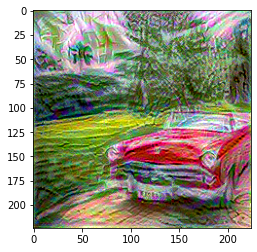

In [45]:
plt.imshow(best_img)
print(best_loss)

In [46]:
image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save("out.jpg")
files.download("out.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>